In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock
%autoreload 2
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock, methyl_mut_burden

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

/tmp/ipykernel_2062618/2977056239.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/041423_somage_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv")
    )
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [8]:
_, _, _, q_all_methyl_df_t, _, _ = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation',
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv")
    )
_, q_all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, q_all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# MBB qnorm

In [9]:
q_mbb = methyl_mut_burden.methylomeMutationalBurden(all_mut_df, q_all_methyl_age_df_t, age_bin_size = 10)

In [10]:
q_all_pair_comp_df = q_mbb.compare_all_pairs()

done with dataset ACC
done with dataset BLCA
done with dataset BRCA
done with dataset CESC
done with dataset CHOL
done with dataset COAD
done with dataset DLBC
done with dataset ESCA
done with dataset GBM
done with dataset HNSC
done with dataset KICH
done with dataset KIRC
done with dataset KIRP
done with dataset LAML
done with dataset LGG
done with dataset LIHC
done with dataset LUAD
done with dataset LUSC
done with dataset MESO
done with dataset OV
done with dataset PAAD
done with dataset PCPG
done with dataset PRAD
done with dataset READ
done with dataset SARC
done with dataset SKCM
done with dataset STAD
done with dataset TGCT
done with dataset THCA
done with dataset THYM
done with dataset UCEC
done with dataset UCS
done with dataset UVM
done comparing all pairs


In [13]:
q_all_pair_comp_df.to_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/050323_mbb_output", "qnrom_all_pair_comp_df_all.parquet"))

In [3]:
q_all_pair_comp_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/050323_mbb_output", "qnrom_all_pair_comp_df_all.parquet"))

In [4]:
q_all_pair_comp_df = q_all_pair_comp_df.loc[:, ['manhattan_diff','mut_diff', 'age_diff', 'dataset']]
q_all_pair_comp_df.columns = ['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Age difference', 'Dataset']
q_all_pair_comp_df['Log-mutation burden\ndifference'] = np.log(q_all_pair_comp_df['Mutation burden\ndifference'] + 1)
#all_pair_comp_df['Log-C>T mutation burden\ndifference'] = np.log(all_pair_comp_df['C>T mutation burden\ndifference'] + 1)
q_all_pair_comp_df['Log age difference'] = np.log(q_all_pair_comp_df['Age difference'] + 1)
#all_pair_comp_df = all_pair_comp_df[['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Log-mutation burden\ndifference', 'Age difference', 'Log age difference']]

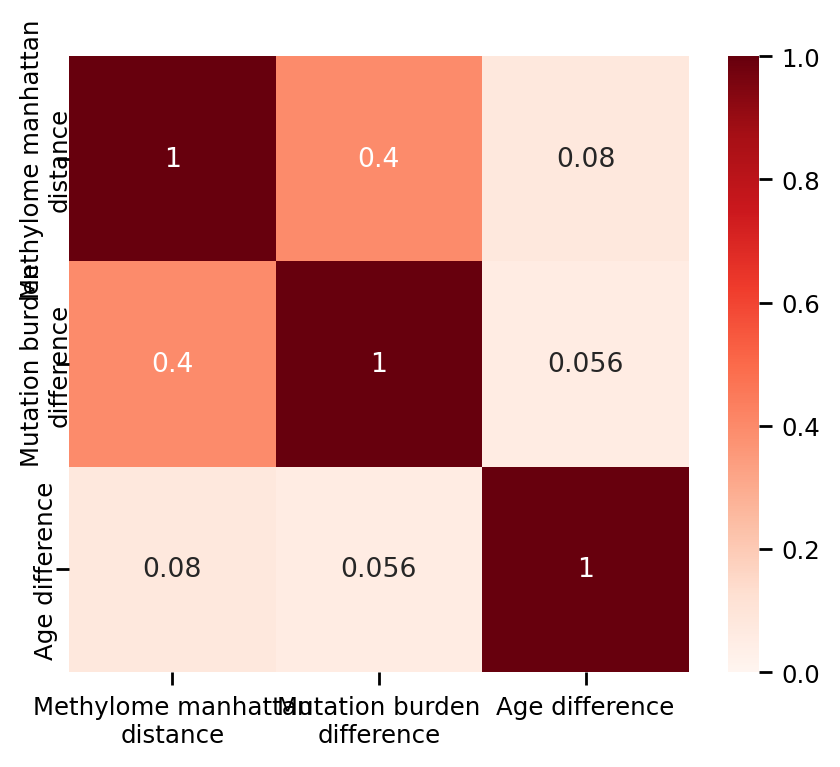

In [15]:
fig, axes = plt.subplots(figsize=(5, 4), dpi =100)
sns.set_context("paper")
sns.heatmap(
    q_all_pair_comp_df[['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Age difference']].corr(method = 'spearman'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes
    )
# angle xtick labels
_ = plt.xticks(rotation=0, ha='center')
_ = plt.yticks(rotation=90, ha='center')
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/fig5G_methylMutBurden.svg', format='svg', dpi=300)



In [ ]:
fig, axes = plt.subplots(figsize=(5, 4), dpi =100)
sns.set_context("notebook", font_scale=1.1)
sns.heatmap(q_all_pair_comp_df[['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Age difference']].corr(method = 'spearman'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)
# angle xtick labels
_ = plt.xticks(rotation=45, ha='right')


/tmp/ipykernel_774412/592380880.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(q_all_pair_comp_df.corr(method = 'pearson'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)


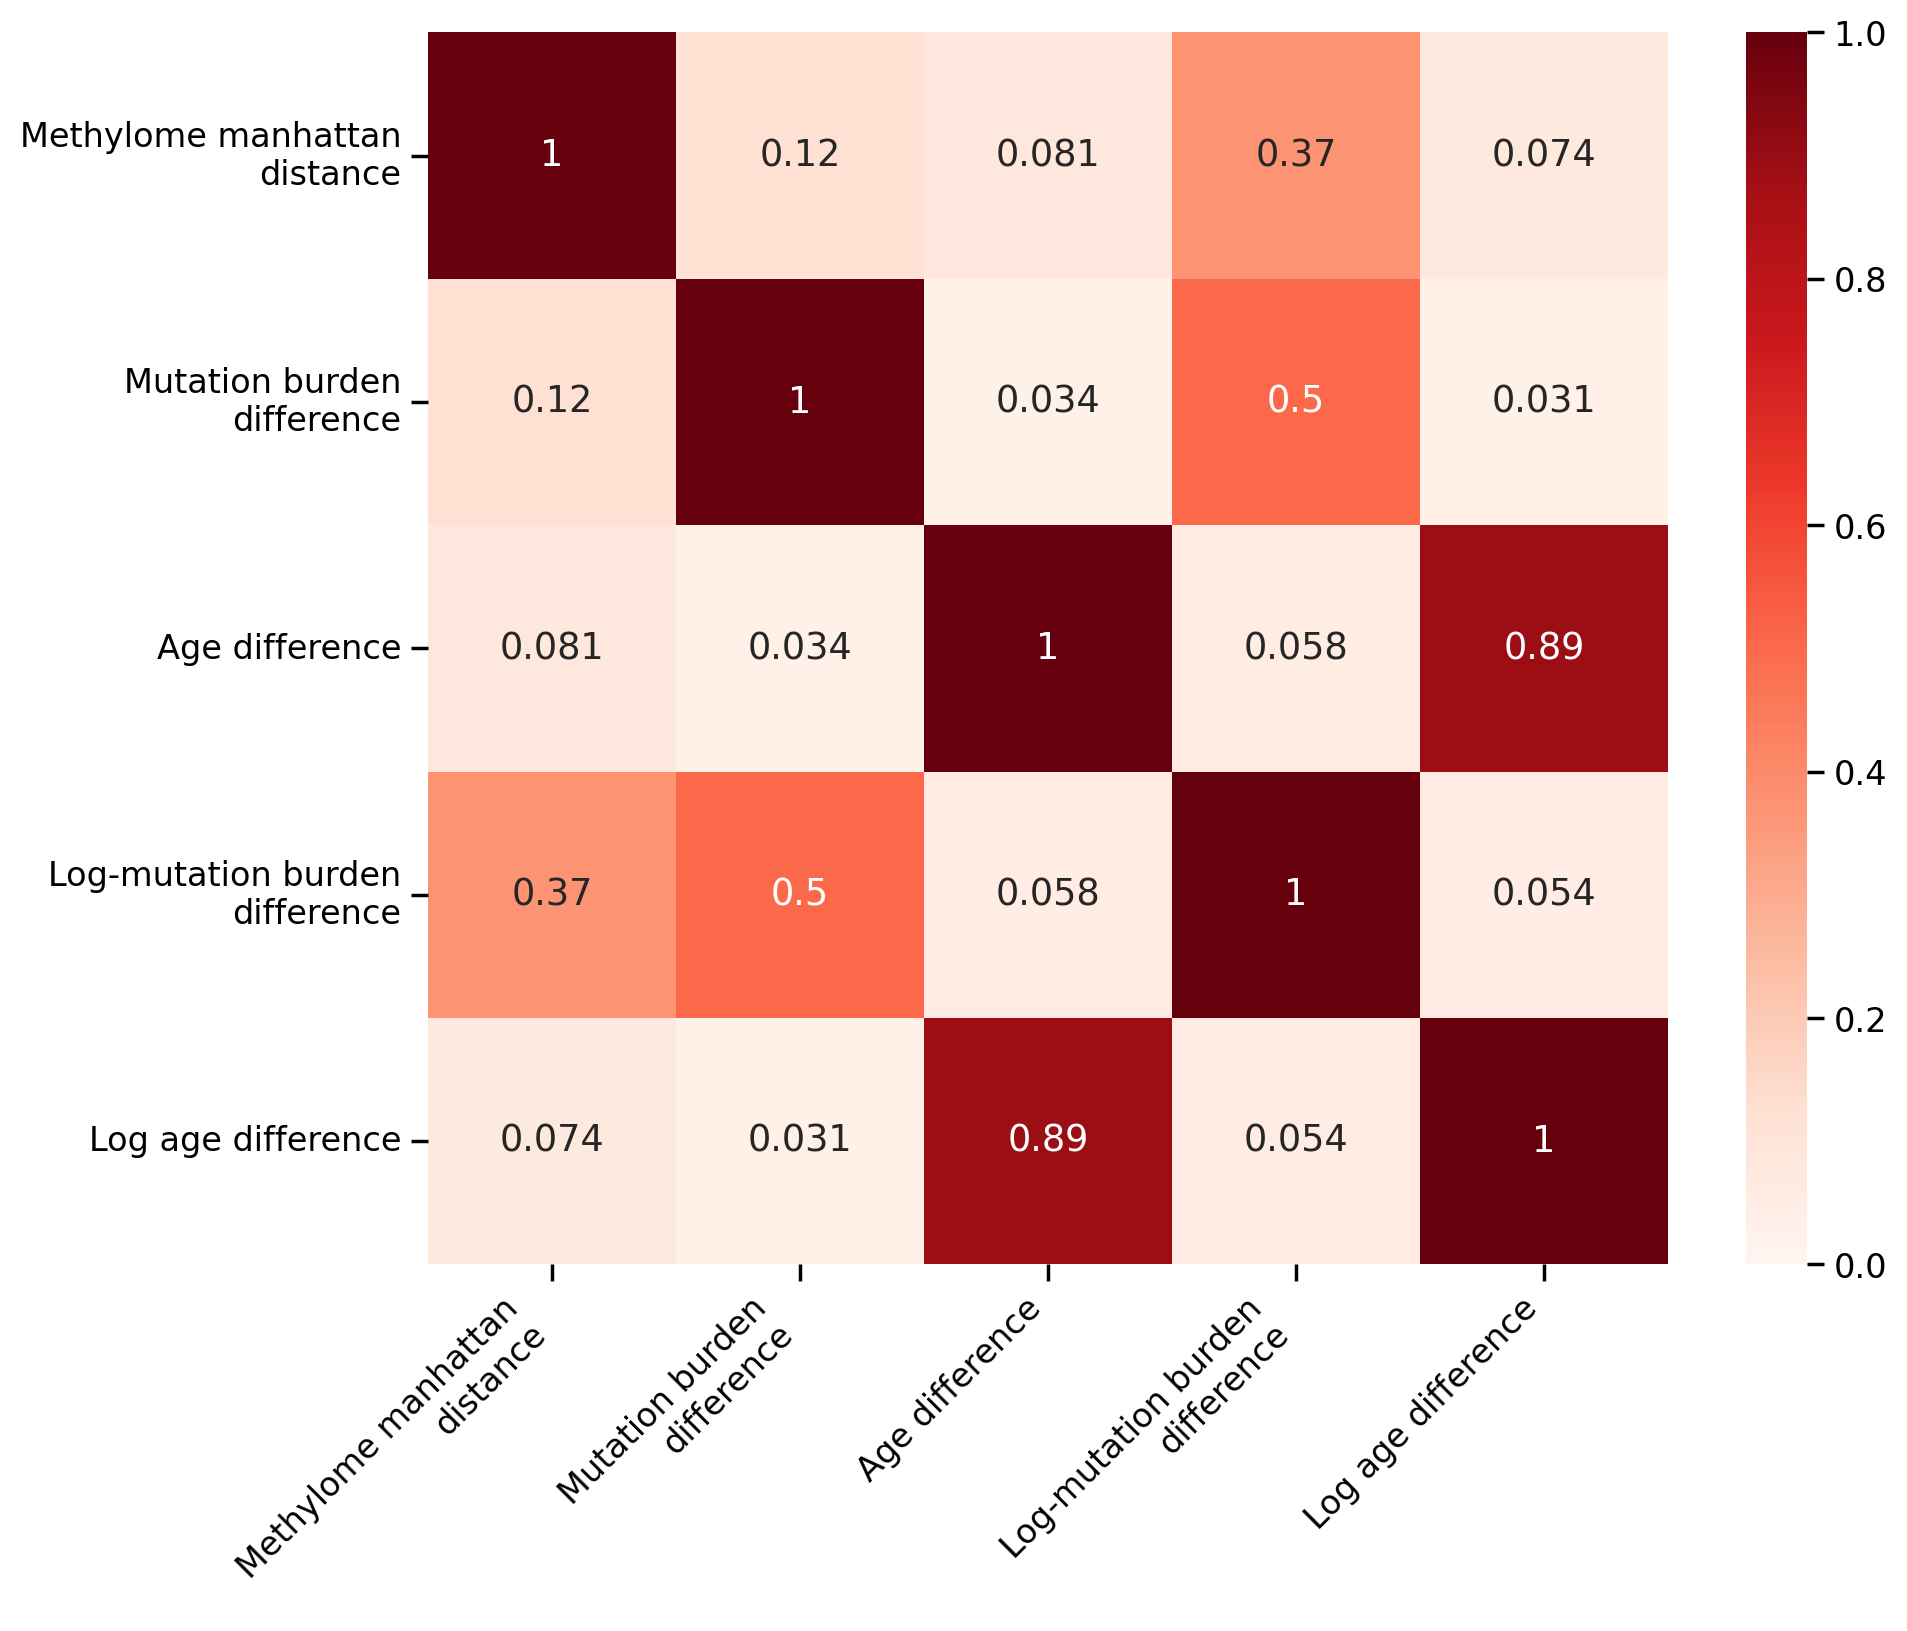

In [17]:
fig, axes = plt.subplots(figsize=(10, 8), dpi =100)
sns.set_context("notebook", font_scale=1.1)
sns.heatmap(q_all_pair_comp_df.corr(method = 'pearson'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)
# angle xtick labels
_ = plt.xticks(rotation=45, ha='right')


## Do MBB calc

In [5]:
mbb = methyl_mut_burden.methylomeMutationalBurden(all_mut_df, all_methyl_age_df_t, age_bin_size = 10)

In [ ]:
all_pair_comp_df = mbb.compare_all_pairs()

In [8]:
all_pair_comp_df.to_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/050323_mbb_output", "all_pair_comp_df_all.parquet"))

In [5]:
all_pair_comp_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/050323_mbb_output", "all_pair_comp_df_all.parquet"))

In [6]:
all_pair_comp_df = all_pair_comp_df.loc[:, ['manhattan_diff','mut_diff', 'age_diff', 'dataset']]
all_pair_comp_df.columns = ['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Age difference', 'Dataset']
all_pair_comp_df['Log-mutation burden\ndifference'] = np.log(all_pair_comp_df['Mutation burden\ndifference'] + 1)
#all_pair_comp_df['Log-C>T mutation burden\ndifference'] = np.log(all_pair_comp_df['C>T mutation burden\ndifference'] + 1)
all_pair_comp_df['Log age difference'] = np.log(all_pair_comp_df['Age difference'] + 1)
#all_pair_comp_df = all_pair_comp_df[['Methylome manhattan\ndistance', 'Mutation burden\ndifference', 'Log-mutation burden\ndifference', 'Age difference', 'Log age difference']]

/tmp/ipykernel_774412/2927230826.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(all_pair_comp_df.corr(method = 'spearman'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)


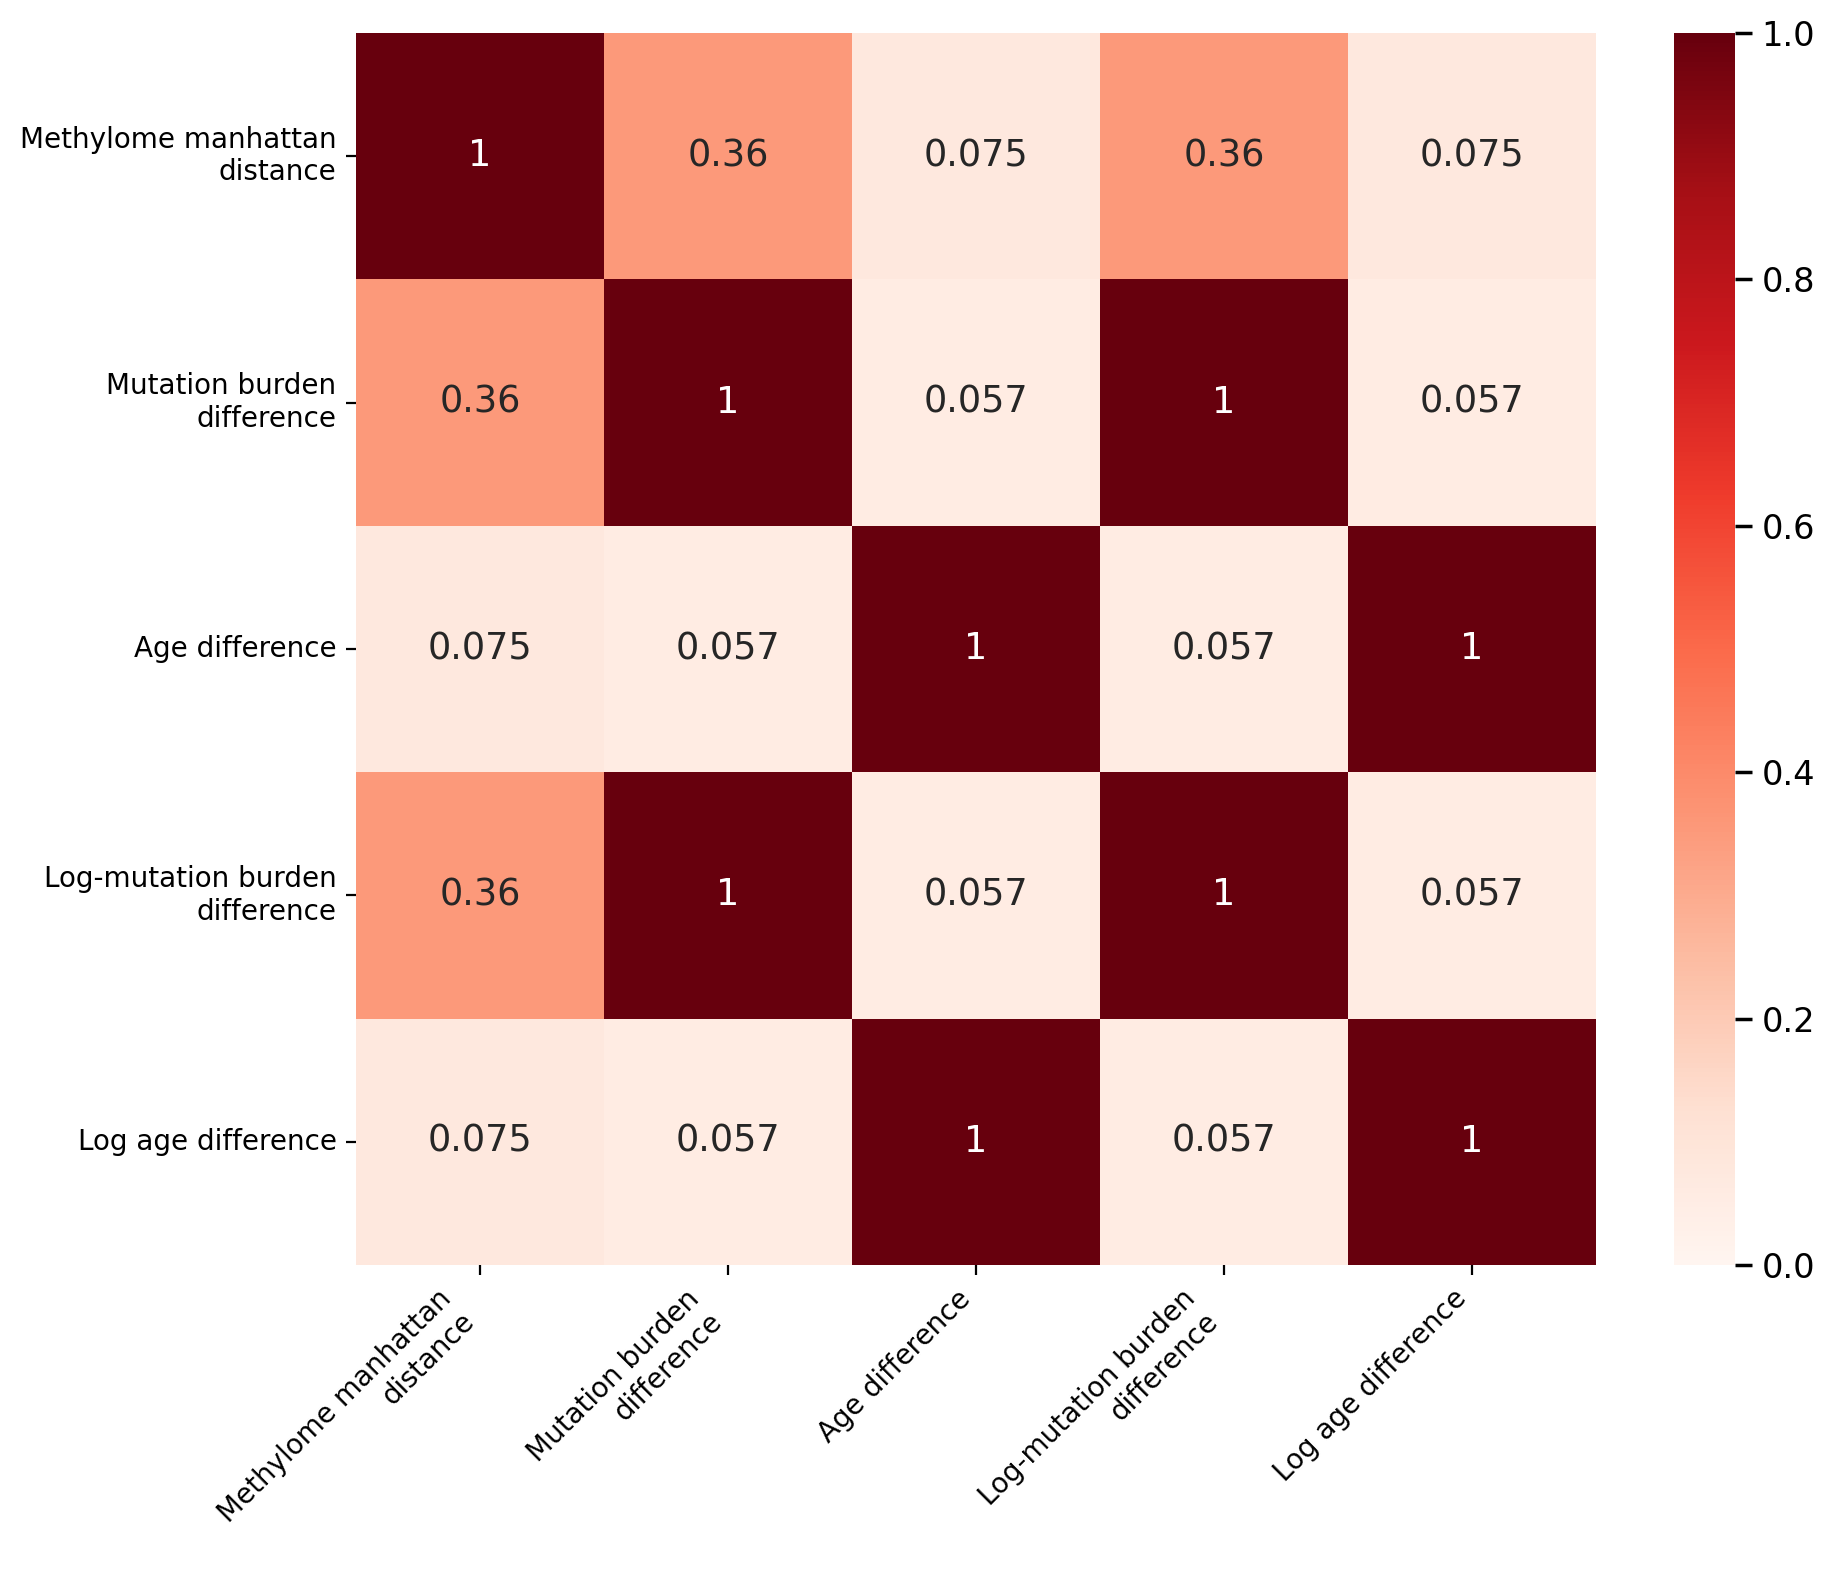

In [7]:
fig, axes = plt.subplots(figsize=(10, 8), dpi =100)
sns.set_context("notebook", font_scale=1.1)
sns.heatmap(all_pair_comp_df.corr(method = 'spearman'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)
# angle xtick labels
_ = plt.xticks(rotation=45, ha='right')


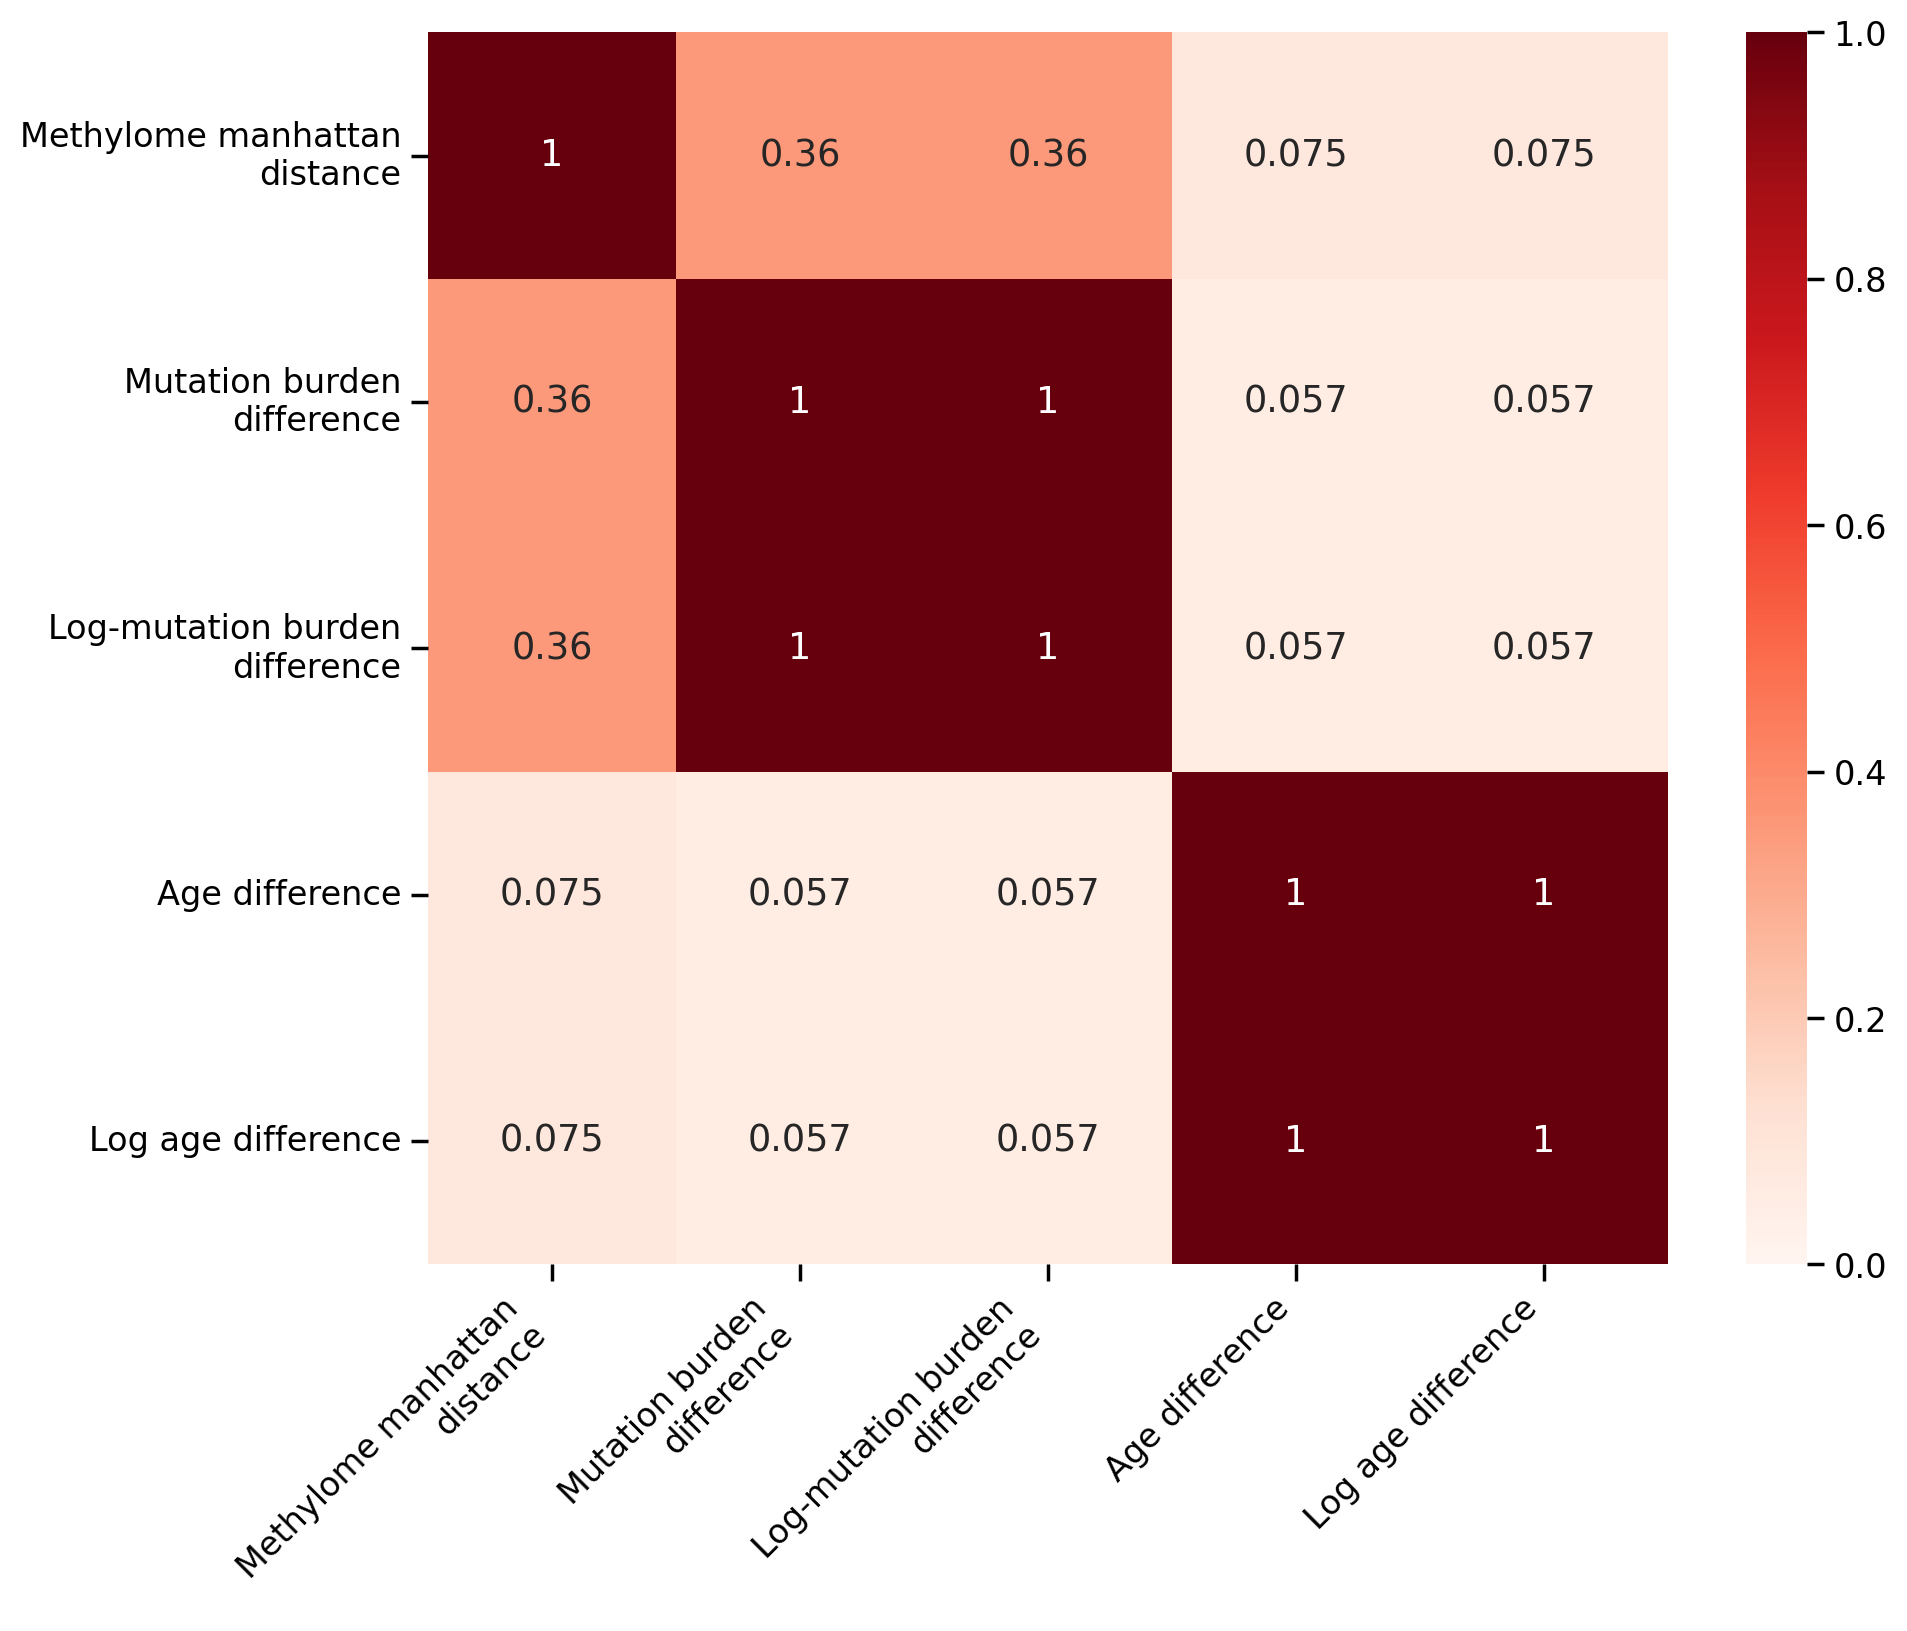

In [16]:
fig, axes = plt.subplots(figsize=(10, 8), dpi =100)
sns.set_context("notebook", font_scale=1.1)
sns.heatmap(all_pair_comp_df.corr(method = 'spearman'), annot=True, cmap="Reds", vmin=0, vmax=1, ax = axes)
# angle xtick labels
_ = plt.xticks(rotation=45, ha='right')


In [26]:
# select Methylome manhattan\ndistance from index and Mutation burden\ndifference	 from columns
corr_by_dset = all_pair_comp_df.groupby('Dataset').corr(method = 'pearson').reset_index().rename({'level_1':'feature'}, axis = 1)

In [30]:
corr_by_dset

,Dataset,feature,Methylome manhattan\ndistance,Mutation burden\ndifference,Age difference,Log-mutation burden\ndifference,Log age difference
0,ACC,Methylome manhattan\ndistance,1.000000,0.066884,0.017019,0.199590,0.021176
1,ACC,Mutation burden\ndifference,0.066884,1.000000,-0.039016,0.734208,-0.027240
2,ACC,Age difference,0.017019,-0.039016,1.000000,0.038584,0.908794
3,ACC,Log-mutation burden\ndifference,0.199590,0.734208,0.038584,1.000000,0.040844
4,ACC,Log age difference,0.021176,-0.027240,0.908794,0.040844,1.000000
...,...,...,...,...,...,...,...
160,UVM,Methylome manhattan\ndistance,1.000000,-0.034857,-0.030817,-0.039521,-0.044266
161,UVM,Mutation burden\ndifference,-0.034857,1.000000,0.081717,0.717606,0.070146
162,UVM,Age difference,-0.030817,0.081717,1.000000,0.079739,0.900676
163,UVM,Log-mutation burden\ndifference,-0.039521,0.717606,0.079739,1.000000,0.074581


In [41]:
[0,1]*3

[0, 1, 0, 1, 0, 1]

In [43]:
corr_by_dset.loc[corr_by_dset['feature'] == 'Methylome manhattan\ndistance'].sort_values('Log-mutation burden\ndifference', ascending = False)

,Dataset,feature,Methylome manhattan\ndistance,Mutation burden\ndifference,Age difference,Log-mutation burden\ndifference,Log age difference
95,OV,Methylome manhattan\ndistance,1.0,0.742566,0.048625,0.597542,-0.051195
145,THYM,Methylome manhattan\ndistance,1.0,0.221236,0.027269,0.493903,0.014967
155,UCS,Methylome manhattan\ndistance,1.0,0.256242,-0.086455,0.428902,-0.072098
50,KICH,Methylome manhattan\ndistance,1.0,0.307684,0.021338,0.386059,0.022424
40,GBM,Methylome manhattan\ndistance,1.0,0.389943,0.196767,0.279862,0.139362
70,LGG,Methylome manhattan\ndistance,1.0,0.072061,0.179631,0.275195,0.161419
25,COAD,Methylome manhattan\ndistance,1.0,0.096282,0.053995,0.245565,0.034473
80,LUAD,Methylome manhattan\ndistance,1.0,0.244538,0.019305,0.209683,0.014086
55,KIRC,Methylome manhattan\ndistance,1.0,0.256905,0.011328,0.202339,0.010654
0,ACC,Methylome manhattan\ndistance,1.0,0.066884,0.017019,0.199590,0.021176


In [36]:
corr_by_dset.loc[corr_by_dset['feature'] == 'Methylome manhattan\ndistance'].sort_values('Mutation burden\ndifference', ascending = False)

,Dataset,feature,Methylome manhattan\ndistance,Mutation burden\ndifference,Age difference,Log-mutation burden\ndifference,Log age difference
95,OV,Methylome manhattan\ndistance,1.0,0.742566,0.048625,0.597542,-0.051195
40,GBM,Methylome manhattan\ndistance,1.0,0.389943,0.196767,0.279862,0.139362
50,KICH,Methylome manhattan\ndistance,1.0,0.307684,0.021338,0.386059,0.022424
55,KIRC,Methylome manhattan\ndistance,1.0,0.256905,0.011328,0.202339,0.010654
155,UCS,Methylome manhattan\ndistance,1.0,0.256242,-0.086455,0.428902,-0.072098
80,LUAD,Methylome manhattan\ndistance,1.0,0.244538,0.019305,0.209683,0.014086
105,PCPG,Methylome manhattan\ndistance,1.0,0.234562,-0.027945,0.193214,-0.011241
145,THYM,Methylome manhattan\ndistance,1.0,0.221236,0.027269,0.493903,0.014967
20,CHOL,Methylome manhattan\ndistance,1.0,0.146326,-0.059573,0.174533,0.018503
140,THCA,Methylome manhattan\ndistance,1.0,0.145591,0.108531,0.141405,0.086438


In [14]:
def compute_corr_and_pvalue_matrix(df):
    columns = df.columns
    corr_matrix = np.zeros((len(columns), len(columns)))
    pvalue_matrix = np.zeros((len(columns), len(columns)))
    
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            corr, pvalue = spearmanr(df[col1], df[col2])
            corr_matrix[i, j] = corr
            pvalue_matrix[i, j] = pvalue
            
    return pd.DataFrame(corr_matrix, columns=columns, index=columns), pd.DataFrame(pvalue_matrix, columns=columns, index=columns)
correlation_matrix, pvalue_matrix = compute_corr_and_pvalue_matrix(all_pair_comp_df.dropna(how = 'any', axis = 0))

In [15]:
pvalue_matrix

,Methylome manhattan\ndistance,Mutation burden\ndifference,Log-mutation burden\ndifference,Age difference,Log age difference
Methylome manhattan\ndistance,0.0,0.0,0.0,0.0,0.0
Mutation burden\ndifference,0.0,0.0,0.0,0.0,0.0
Log-mutation burden\ndifference,0.0,0.0,0.0,0.0,0.0
Age difference,0.0,0.0,0.0,0.0,0.0
Log age difference,0.0,0.0,0.0,0.0,0.0
